In [16]:
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate,train_test_split
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from numpy import genfromtxt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")

# Reading data from dataset file
data_set = pd.read_csv("data_set.csv") 

# make data frame for scenechange with specific ID
scene_df = pd.DataFrame(columns=['s_video_id','c_scene_change_ffmpeg_ratio30'])

# Calculate resolution 
encode_WidthHeight= data_set['e_width']*data_set['e_height']

# division of each scene by duration in seconds
AVG_Scene_Change= data_set['c_scene_change_ffmpeg_ratio30']*60/data_set['s_duration']

# Pick desire data from data_set
df=pd.DataFrame({'c_scene_change_ffmpeg_ratio30':AVG_Scene_Change ,
                 's_duration': data_set['s_duration'], 
                 's_video_id':data_set['s_video_id'],
                 'e_framerate':data_set['e_framerate'],
                 's_height': data_set['s_height'], 
                 's_storage_size': data_set['s_storage_size'], 
                 'encode_WidthHeight': encode_WidthHeight,
                 't_average_bitrate': data_set['t_average_bitrate'], 
                 'e_crf': data_set['e_crf'], 
                 's_width' : data_set['s_width'], 
                 't_average_vmaf': data_set['t_average_vmaf']})

df.dropna(inplace=True)
df.head()

,c_scene_change_ffmpeg_ratio30,s_duration,s_video_id,e_framerate,s_height,s_storage_size,encode_WidthHeight,t_average_bitrate,e_crf,s_width,t_average_vmaf
0,10.224852,65,8,50.0,1080,521709628,2073600,31214,18,1920,97.204616
1,10.224852,65,8,50.0,1080,521709628,230400,2750,18,1920,67.255472
2,10.224852,65,8,50.0,1080,521709628,921600,10777,18,1920,90.423618
3,10.224852,65,8,50.0,1080,521709628,518400,5990,18,1920,83.276829
4,10.224852,65,8,50.0,1080,521709628,331776,3766,18,1920,75.562682


In [17]:
# remove outliers of scene_change_ffmpeg_ratio30 by ITU-T method

shape=df['c_scene_change_ffmpeg_ratio30'].shape[0]
IQR=df['c_scene_change_ffmpeg_ratio30'].describe()[6]-df['c_scene_change_ffmpeg_ratio30'].describe()[4]
IQR2=IQR*3
threshold=df['c_scene_change_ffmpeg_ratio30'].describe()[6]+IQR2
for i in range(shape):
    if(df.iloc[i, 0:1].values[0] >= threshold):
        df.iloc[i, 0:1]=np.nan

df.dropna(inplace=True)
df.shape

(9944, 11)

In [18]:
# remove outliers of storage_size by ITU-T method

shape=df['s_storage_size'].shape[0]
IQR=df['s_storage_size'].describe()[6]-df['s_storage_size'].describe()[4]
IQR2=IQR*3
threshold=df['s_storage_size'].describe()[6]+IQR2
for i in range(shape):
    if(df.iloc[i, 5:6].values[0] >= threshold):
        df.iloc[i, 5:6]=np.nan
        

df.dropna(inplace=True)
df.shape

(8485, 11)

In [19]:
# remove outliers of duration by ITU-T method

shape=df['s_duration'].shape[0]
IQR=df['s_duration'].describe()[6]-df['s_duration'].describe()[4]
IQR2=IQR*3
threshold=df['s_duration'].describe()[6]+IQR2
for i in range(shape):
    if(df.iloc[i, 1:2].values[0] >= threshold):
        df.iloc[i, 1:2]=np.nan

df.dropna(inplace=True)
#df.head()

In [20]:
# one-hold-out cross validation

ID = df['s_video_id'].unique()

# confi & Predicted values for all used models using empty matrices
confi_SVR = np.empty([ID.size])
predict_SVR=np.empty([1])

confi_LinearReg = np.empty([ID.size])
predict_LinearReg=np.empty([1])

confi_RF = np.empty([ID.size])
predict_RF=np.empty([1])


Goal_yTest = np.empty([1])
Goal_XTest = np.empty([1,9])
Goal_LinearReg = np.empty([1])
Goal_RF = np.empty([1])


New_id=pd.DataFrame()
Old_id=pd.DataFrame()

for i in range(42):
    df_test = df[df['s_video_id'].isin(ID[i:i+1])]
    df_train = df[df['s_video_id'].isin(ID[i:i+1])==False]
    Old_id = df_test['s_video_id']

    df_train = df_train.drop(['s_video_id'], axis=1);
    df_test = df_test.drop(['s_video_id'], axis=1);
    train_num = df_train.shape[0]

    # Split data into train and test set
    
    X_train = np.array(df_train.drop(['t_average_vmaf'], 1))
    y_train = np.array(df_train['t_average_vmaf'])

    X_test = np.array(df_test.drop(['t_average_vmaf'], 1))
    y_test = np.array(df_test['t_average_vmaf'])
    X_test_real = X_test;

    train_test = np.append(X_train,X_test,axis = 0)
    train_test = preprocessing.scale(train_test)

    X_train = train_test[0:train_num,:]
    X_test = train_test[train_num:,:]

# Create SVR model
SVR = svm.SVR()
SVR.fit(X_train, y_train)
confi_SVR[i] = SVR.score(X_test, y_test)
temp_SVR= SVR.predict(X_test)
predict_SVR = np.append(predict_SVR,temp_SVR)
Goal_yTest = np.append(Goal_yTest,y_test)
Goal_XTest = np.concatenate((Goal_XTest,X_test_real), 0) 
Iden =pd.concat([New_id, Old_id], axis=0)

# Create Linear Regression model
LinearReg = LinearRegression()
LinearReg.fit(X_train, y_train)
confi_LinearReg[i] = LinearReg.score(X_test, y_test)
temp_LinearReg=LinearReg.predict(X_test)
predict_LinearReg= np.append(predict_LinearReg,temp_LinearReg)
Goal_LinearReg = np.append(Goal_LinearReg,y_test)



# Create Random Forest model
RF = RandomForestRegressor(n_estimators = 2000, random_state = 42)
RF.fit(X_train, y_train)
confi_RF[i] = RF.score(X_test, y_test)
temp_RF=RF.predict(X_test)
predict_RF= np.append(predict_RF,temp_RF)
Goal_RF = np.append(Goal_RF,y_test)



In [21]:
# Make data frame for each and save to excel file
Goal_yTest = pd.DataFrame(Goal_yTest)
Goal_yTest.to_excel('Goal_yTest.xlsx');
Goal_XTest = pd.DataFrame(Goal_XTest)
Goal_XTest.to_excel('Goal_XTest.xlsx');
predict_SVR = pd.DataFrame(predict_SVR)
predict_SVR.to_excel('predict_SVR.xlsx');
Goal_LinearReg = pd.DataFrame(Goal_LinearReg)
Goal_LinearReg.to_excel('Goal_LinearReg.xlsx');
predict_LinearReg = pd.DataFrame(predict_LinearReg)
predict_LinearReg.to_excel('predict_LinearRegg.xlsx');
Goal_RF = pd.DataFrame(Goal_RF)
Goal_RF.to_excel('Goal_RF.xlsx');
predict_RF = pd.DataFrame(predict_RF)
predict_RF.to_excel('predict_RF.xlsx');
Iden.to_excel('id.xlsx');

Text(0, 0.5, 'VMAF')

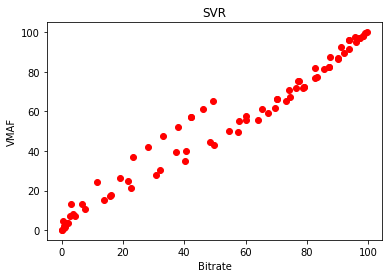

In [22]:
# plot each ML Method 
plt.scatter(Goal_yTest,predict_SVR,color='r')
plt.title("SVR")
plt.xlabel("Bitrate")
plt.ylabel("VMAF")

Text(0, 0.5, 'VMAF')

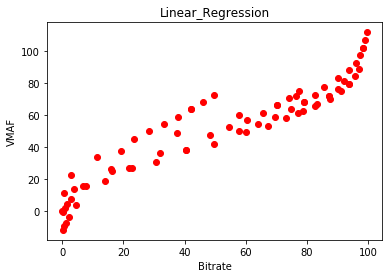

In [23]:
plt.scatter(Goal_LinearReg,predict_LinearReg,color='r')
plt.title("Linear_Regression")
plt.xlabel("Bitrate")
plt.ylabel("VMAF")

Text(0, 0.5, 'VMAF')

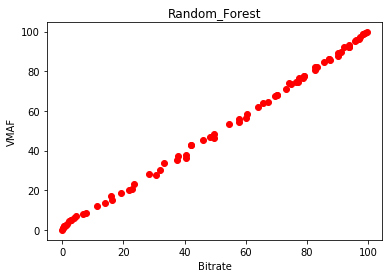

In [24]:
plt.scatter(Goal_RF,predict_RF,color='r')
plt.title("Random_Forest")
plt.xlabel("Bitrate")
plt.ylabel("VMAF")